In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard.writer import SummaryWriter

from sklearn.model_selection import train_test_split

from common import data
from common.training import training_loop, get_predictions

from algos.supervised import SupervisedEngine

from common.models import simple_conv
from common import metrics
from common.models.modutils import load_model


# Hyperparameters

In [3]:
log_dir = "./final/baseline_sim"

horizon = 1024
stride = 512

batch_size = 16

num_epochs = 10

learning_rate = 1e-4

weight_decay = 1e-1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# Datasets

In [4]:
paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)


In [5]:
m_data_train = data.Marconi100Dataset(train, scaling=data.Scaling.STANDARD)
m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.STANDARD)


Loading: 100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


In [6]:
train_loader = DataLoader(
    data.UnfoldedDataset(m_data_train, horizon=horizon, stride=stride),
    batch_size,
    shuffle=True,
)
test_loader = DataLoader(
    data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride),
    batch_size,
    shuffle=False,
)


# Model

In [7]:
base_width = 128
down_layers = 2
dilations = [False, True]

backbone = simple_conv.Encoder(data.NUM_FEATURES, down_layers, base_width, dilations)
model = simple_conv.SimpleSegConv(backbone, 1)

optim = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_sched = CosineAnnealingLR(optim, num_epochs)
engine_supervised = SupervisedEngine(
    model, device, optimizer=optim, lr_scheduler=lr_sched
)


# Training

In [8]:
with SummaryWriter(log_dir + "/logs") as writer:
    training_loop(
        engine=engine_supervised,
        num_epochs=num_epochs,
        train_dataloader=train_loader,
        test_dataloader=test_loader,
        writer=writer,
        save_path=log_dir + "/models",
    )


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 96 from PyObject


Epoch 0 - train_loss=0.200 - test_loss=0.199 - cost=0.140 - threshold=-1.179 - lr=1.00e-04


Epoch 1 - train_loss=0.126 - test_loss=0.150 - cost=0.118 - threshold=-1.772 - lr=9.76e-05


Epoch 2 - train_loss=0.129 - test_loss=0.140 - cost=0.118 - threshold=-1.748 - lr=9.05e-05


Epoch 3 - train_loss=0.116 - test_loss=0.138 - cost=0.136 - threshold=-0.887 - lr=7.94e-05


Epoch 4 - train_loss=0.114 - test_loss=0.132 - cost=0.127 - threshold=-1.690 - lr=6.55e-05


Epoch 5 - train_loss=0.132 - test_loss=0.134 - cost=0.120 - threshold=-2.122 - lr=5.00e-05


Epoch 6 - train_loss=0.089 - test_loss=0.123 - cost=0.106 - threshold=-1.819 - lr=3.45e-05


Epoch 7 - train_loss=0.098 - test_loss=0.127 - cost=0.109 - threshold=-2.304 - lr=2.06e-05


Epoch 8 - train_loss=0.069 - test_loss=0.124 - cost=0.104 - threshold=-2.199 - lr=9.55e-06


Epoch 9 - train_loss=0.094 - test_loss=0.122 - cost=0.106 - threshold=-2.153 - lr=2.45e-06


# Evaluating

In [9]:
load_model(model, log_dir + "/models/model_9.pth", device);

In [10]:
# Cost model
cmodel = metrics.default_cmodel()


In [11]:
scores, labels = get_predictions(engine_supervised.predict, test_loader)


100%|██████████| 41/41 [00:07<00:00,  5.81it/s]


In [12]:
cmodel.fit(scores, labels).optimize()


(-2.1526075363159265, 0.10601213)

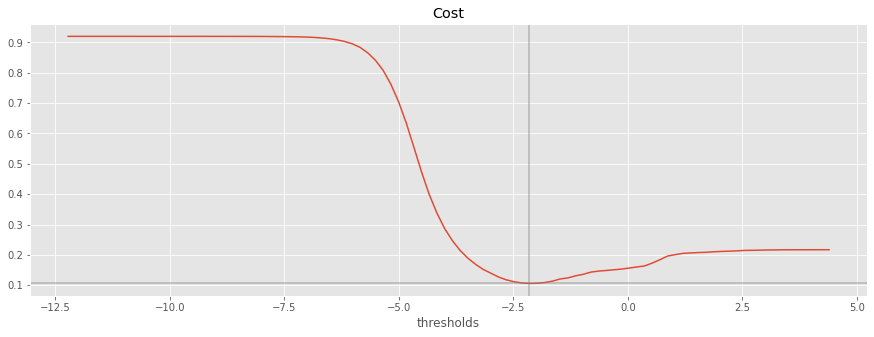

In [13]:
metrics.plot_cost(cmodel)


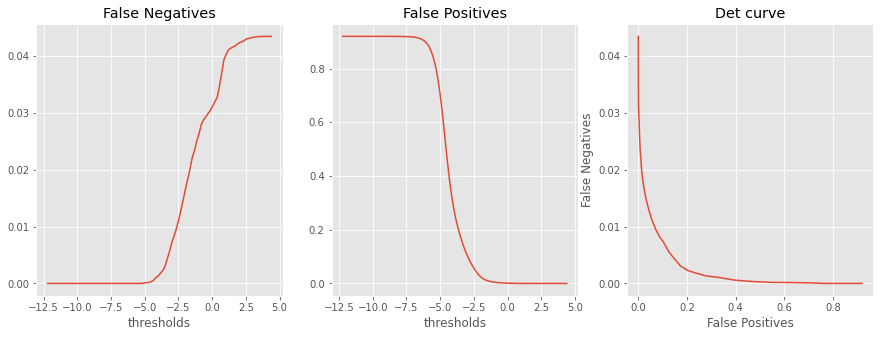

In [14]:
metrics.plot_errors_curve(
    cmodel.false_positives, cmodel.false_negatives, cmodel.thresholds, figsize=(15, 5)
)


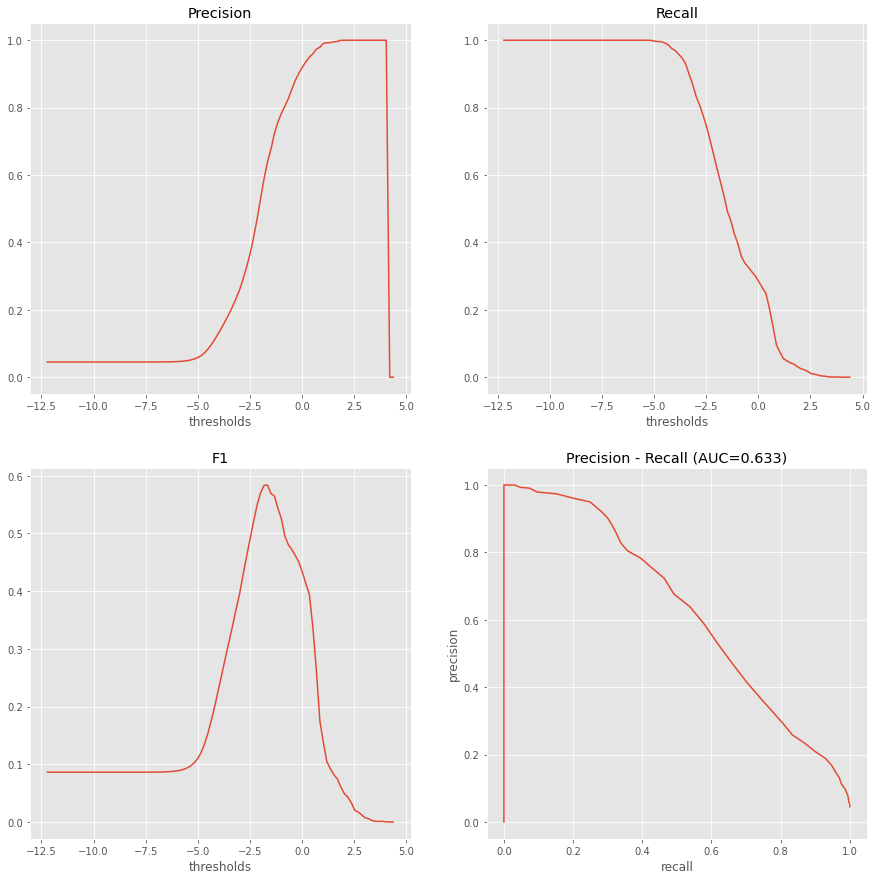

In [15]:
pr, rec, f1 = metrics.precision_recall_f1(
    cmodel.false_positives, cmodel.false_negatives
)
metrics.plot_precision_recall_f1_curve(pr, rec, f1, cmodel.thresholds)
